### Experimental Objective: Abrupt Drift Detection (OCSVM)

The primary objective of this experiment is to evaluate the sensitivity of **One-Class SVM (OCSVM)** to *abrupt* covariate drift. Unlike gradual drift (which simulates slow deterioration), abrupt drift represents a sudden, systemic shift in the data distribution—akin to a sensor calibration error or a rapid population shock.

**Experimental Design: Affine Remapping**
We simulate this distributional shock using **Affine Remapping** (Min-Max Transformation). This technique re-scales the feature space via two parameters:
* **Downward Shift ($\delta = -0.4$):** A 40% reduction in the feature's location.
* **Range Expansion ($\sigma = 1.5$):** A 1.5x scaling of the feature's spread.

**1.2 Methodology & Workflow**
The experiment follows a strict "split-first" protocol to prevent data leakage:
1.  **Baseline Calibration:** The model is trained on a 70% temporal baseline ($\nu=0.2$) to establish a "normality profile" and a reference anomaly rate.
2.  **Global Drift Application:** Unlike gradual drift, the Affine Remapping is applied to the `entire 30% test set` simultaneously. This creates an immediate "step-change" in the data structure.
3.  **Scenarios:**
    * **Univariate:** Remapping applied only to `Glucose`.
    * **Multivariate:** Remapping applied simultaneously to `Glucose`, `BMI`, and `Age`.
4.  **Validation:** Sensitivity is quantified via the **Detection Ratio** and statistically confirmed using **K-S Tests** to verify the divergence of the remapped distributions.

In [1]:
# Importing all necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.svm import OneClassSVM
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import shap
import warnings

# Load the UNIMPUTED (raw) data to prevent data leakage
data_path = Path("data/interim/pima_step1_clean.csv")
df = pd.read_csv(data_path)

# Create Missingness Flags from the raw NaN values
cols_with_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols_with_missing:
    df[f"{col}_is_missing"] = df[col].isna().astype(int)

print("Loaded pima_step1_clean.csv and created missingness flags.")
print("Dataset loaded successfully. Shape:", df.shape)
df.head()

Loaded pima_step1_clean.csv and created missingness flags.
Dataset loaded successfully. Shape: (768, 14)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_is_missing,BloodPressure_is_missing,SkinThickness_is_missing,Insulin_is_missing,BMI_is_missing
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1,0,0,0,1,0
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0,0,0,0,1,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1,0,0,1,1,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,0,0,0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,0,0,0,0,0


#### Data Partitioning for Simulation

**Purpose:** To create a baseline "training" set and a "test" set to simulate a post-deployment scenario.

**Partitioning Strategy:**
* **Method:** We use a **temporal (sequential)** 70/30 split, taking the first 70% of samples as the baseline set and the last 30% as the test set. This is done *before* any imputation or scaling to prevent data leakage.
* **Baseline Set (`X_base_raw`):** 537 samples (70%)
* **Test Set (`X_test_raw`):** 231 samples (30%)

**Rationale:** This temporal split is essential for a realistic drift simulation. It mimics a production environment where a model, trained on historical data (`X_base_raw`), must process new, incoming "future" data (`X_test_raw`). By fitting all preprocessing steps only on the baseline data, we ensure a leak-free pipeline.


In [2]:
# Performing temporal split (BEFORE imputation/scaling) to avoid leakage
# Now we will separate features and target (unsupervised drift detection uses X only for training)
X = df.drop(columns='Outcome') # Define features (X) for training
y = df['Outcome'] # Storing target (y) for reporting/evaluation later

# Ensure chronological ordering
X = X.sort_index()
y = y.sort_index()

# Computing split boundary: 70% of the stream -> baseline
split_point = int(0.7 * len(X)) # With N=768, this gives us 537

# Create raw (pre-imputation, pre-scaling) baseline and test partitions
X_base_raw = X.iloc[:split_point].copy()
X_test_raw = X.iloc[split_point:].copy()
y_base = y.iloc[:split_point].copy()
y_test = y.iloc[split_point:].copy()

# Now we will run sanity checks (shapes and non-overlap)
assert len(X_base_raw) == 537 and len(X_test_raw) == 231
assert X_base_raw.index.max() < X_test_raw.index.min()

print(f"Baseline raw shape (with NaNs): {X_base_raw.shape}")
print(f"Test raw shape (with NaNs): {X_test_raw.shape}")


Baseline raw shape (with NaNs): (537, 13)
Test raw shape (with NaNs): (231, 13)


#### Feature Type Identification

**Purpose:** Separate binary indicators from continuous features for differential preprocessing.

**Feature Classification:**
- Continuous (8 features): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age
- Binary indicators (5 features): Glucose_is_missing, BloodPressure_is_missing, SkinThickness_is_missing, Insulin_is_missing, BMI_is_missing

**Why This Matters:** Binary {0,1} flags must remain unscaled to preserve semantic meaning; continuous features require z-score normalization for Isolation Forest and other distance-based algorithms.

In [3]:

# Identify Feature Groups
indicator_cols = [col for col in X_base_raw.columns if col.endswith('_is_missing')]
continuous_cols = [col for col in X_base_raw.columns if col not in indicator_cols]

print(f"Continuous features ({len(continuous_cols)}): {continuous_cols}")
print(f"Binary indicators ({len(indicator_cols)}): {indicator_cols}")


Continuous features (8): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Binary indicators (5): ['Glucose_is_missing', 'BloodPressure_is_missing', 'SkinThickness_is_missing', 'Insulin_is_missing', 'BMI_is_missing']


#### Feature Imputation and Scaling

**Purpose:** To impute missing values and standardize continuous features, fitting transformers *only* on the baseline data to prevent leakage.

**Pipeline Strategy:**
1.  **Imputation:** A `SimpleImputer` (with `strategy="median"`) is **fit** on the continuous features of the `X_base_raw` set.
2.  **Scaling:** A `StandardScaler` (z-score normalization) is then **fit** on the *imputed* baseline data (`X_base_imputed_cont`).
3.  **Transformation:** Both the fitted imputer and scaler are applied (in order) to transform the baseline and test sets.
4.  **Indicators:** Binary indicator columns are left untouched and re-combined with the processed continuous features.

**Rationale:** Imputation is required to handle missing data before scaling. Standardization is necessary for Isolation Forest's distance-based calculations. Fitting these transformers *only* on the baseline data is critical to mimic a real-world deployment scenario and prevent data leakage.


In [4]:
# Here we will initialize our transformers
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

# Setting output to Pandas for easy column management
imputer.set_output(transform="pandas")
scaler.set_output(transform="pandas")

# Fit the imputer to find the median of baseline continuous columns
imputer.fit(X_base_raw[continuous_cols])

# Applying imputation to the baseline to create a "clean" version for fitting the scaler
X_base_imputed_cont = imputer.transform(X_base_raw[continuous_cols])

# Now we will fit the scaler ONLY on the imputed baseline data
scaler.fit(X_base_imputed_cont)

# Create the X_base_scaled (For Model Training)
# Apply the scaler to the imputed baseline data
X_base_scaled_cont = scaler.transform(X_base_imputed_cont)

# Recombining scaled continuous features + unscaled binary indicators
X_base_scaled = pd.concat([X_base_scaled_cont, X_base_raw[indicator_cols]], axis=1)

# Create X_test (Imputed, Unscaled)
# 1. Impute the raw test set using the baseline-fitted imputer
X_test_imputed_cont = imputer.transform(X_test_raw[continuous_cols])

# 2. Recombine with binary indicators to create the "clean" unscaled test set
X_test = pd.concat([X_test_imputed_cont, X_test_raw[indicator_cols]], axis=1)

# Create X_test_scaled (The NON-DRIFTED Test Set)
# 1. Now we will scale the imputed test set (X_test_imputed_cont)
X_test_scaled_cont = scaler.transform(X_test_imputed_cont)

# 2. Recombining to create the final, non-drifted scaled test set
X_test_scaled = pd.concat([X_test_scaled_cont, X_test_raw[indicator_cols]], axis=1)

print("Preprocessing complete. Imputer and Scaler fit ONLY on baseline data.")
print(f"CREATED: X_base_scaled (shape: {X_base_scaled.shape})")
print(f"CREATED: X_test (imputed, unscaled) (shape: {X_test.shape})")
print(f"CREATED: X_test_scaled (baseline for K-S test) (shape: {X_test_scaled.shape})")

Preprocessing complete. Imputer and Scaler fit ONLY on baseline data.
CREATED: X_base_scaled (shape: (537, 13))
CREATED: X_test (imputed, unscaled) (shape: (231, 13))
CREATED: X_test_scaled (baseline for K-S test) (shape: (231, 13))


#### Min/Max Affine Drift Function

**Purpose**: Create a reusable function to apply min/max affine transformation that simulates abrupt population drift.

**Transformation Formula**:

$$x_{drifted} = \frac{x - f_{min}}{f_{range}} \cdot (max_t - min_t) + min_t$$

Where:
- **$f_{min}$, $f_{max}$**: Original feature minimum and maximum
- **$min_t = f_{min} \times shift\_factor$**: New minimum (shifted)
- **$max_t = min_t + f_{range} \times range\_factor$**: New maximum (shifted + stretched)

**Key Parameters**:
- **shift_factor = 0.4**: Scales new minimum to 40% of original (downward shift)
- **range_factor = 1.5**: Expands range by 1.5× (increased variability)


In [5]:
# Define Min/Max Affine Drift Function
shift_factor = 0.4
range_factor = 1.5

def apply_minmax_drift(X_data, X_base_stats, features, shift_f, range_f, verbose=True):
    """
    Apply min/max affine transformation to specified features using baseline 
    statistics to define the drift, correctly handling NaN values.
    """
    import pandas.api.types as pd_types
    X_drifted = X_data.copy()
    if verbose:
        print("="*70)
        print("MIN/MAX AFFINE DRIFT TRANSFORMATION (NaN-Safe - BASELINE-FITTED)")
        print(f"Shift Factor: {shift_f} | Range Factor: {range_f}")
        print(f"Features: {features}")
        print("="*70)

    for feature in features:
        if feature not in X_drifted.columns:
            print(f"Warning: {feature} not found. Skipping.")
            continue
        
        # Get f_min and f_range from the BASELINE data 
        if feature not in X_base_stats:
             print(f"Error: Baseline stats not found for {feature}. Skipping.")
             continue
             
        f_min = X_base_stats[feature]['f_min']
        f_range = X_base_stats[feature]['f_range']
        f_max = f_min + f_range
        
        # Prepare data for transformation
        original_values = X_drifted[feature]
        new_values = original_values.copy()
        
        # Check for zero range, though this should be handled by baseline stats prep
        if f_range == 0:
            print(f"Warning: {feature} has zero baseline range. Skipping.")
            continue
            
        # Compute the new target bounds (uses BASELINE f_min/f_range)
        min_t = f_min * shift_f
        max_t = min_t + (f_range * range_f)
        
        # Create a mask for NON-NaN values
        nan_mask = ~np.isnan(original_values)
        
        # Applying the affine transformation (remapping) ONLY to non-NaN values
        # The normalization uses the BASELINE f_min and f_range
        normalized = (original_values[nan_mask] - f_min) / f_range
        drifted_values = normalized * (max_t - min_t) + min_t
        
        # Place the new, drifted values back into the array
        new_values[nan_mask] = drifted_values
        X_drifted[feature] = new_values

        if verbose:
            original_mean = np.nanmean(original_values)
            new_mean = np.nanmean(new_values)
            original_std = np.nanstd(original_values)
            new_std = np.nanstd(new_values)
            
            mean_shift = (new_mean / original_mean - 1) * 100 if original_mean else 0
            std_change = (new_std / original_std - 1) * 100 if original_std else 0
            
            print(f"\n{feature}:")
            print(f" Original (BASELINE): [{f_min:.3f}, {f_max:.3f}]")
            print(f" Drifted (TARGET): [{min_t:.3f}, {max_t:.3f}]")
            print(f" Test Set: mean={original_mean:.3f}, std={original_std:.3f}")
            print(f" Drifted Test: mean={new_mean:.3f}, std={new_std:.3f}")
            print(f" → Mean shift: {mean_shift:+.3f}% | Std change: {std_change:+.3f}%")
    
    if verbose:
        print("="*70)
    return X_drifted

#### Train One-Class SVM on Baseline Data

**Purpose:** Train the One-Class Support Vector Machine (OCSVM) anomaly detector exclusively on the baseline data to establish a "normality profile."

**Hyperparameter Strategy:** We use the $\nu$ parameter, which acts as an upper bound on the fraction of outliers. We set $\nu = 0.2$ to align with the $20\%$ contamination rate used in the original Isolation Forest experiment, maintaining a consistent baseline tolerance. The **Radial Basis Function (RBF)** kernel is used with `gamma='scale'` for a robust initial fit.

**Expected Behavior:**
* The OCSVM learns the boundary separating the "normal" (non-drifted) data points from outliers in the baseline set.
* The model's decision function score (distance from the hyperplane) will be used to detect the new, shifted populations introduced during the drift experiments.

In [6]:
#  Train One-Class SVM on Baseline 
# nu is set to 0.2 to match the expected anomaly rate (contamination=0.2) from the objective.

# Now we will initialize the One-Class SVM
oc_svm = OneClassSVM(
    kernel='rbf',    # Use the Radial Basis Function kernel
    nu=0.2,          # Equivalent to contamination=0.2 from objective
    gamma='scale',   # Kernel coefficient for 'rbf'
)

# Printing the training details to the console
print("ONE-CLASS SVM TRAINING")
print(f"\nTraining on baseline data: {X_base_scaled.shape}")
print(f"Features: {X_base_scaled.shape[1]}")
print(f"\nHyperparameters (from objective):")
print(f" • kernel: rbf")
print(f" • nu: 0.2 (20% expected anomaly upper bound)")
print(f" • gamma: scale (Default calculation)")

# Fit the model ONLY on the baseline data
oc_svm.fit(X_base_scaled)

# Confirm model training is complete and show key properties
print(f"\nModel trained successfully")
print(f" • Decision Boundary: decision_function = 0 (Anomaly if score < 0)")
print("="*80)

ONE-CLASS SVM TRAINING

Training on baseline data: (537, 13)
Features: 13

Hyperparameters (from objective):
 • kernel: rbf
 • nu: 0.2 (20% expected anomaly upper bound)
 • gamma: scale (Default calculation)

Model trained successfully
 • Decision Boundary: decision_function = 0 (Anomaly if score < 0)


SHAP explainer created successfully (using oc_svm.decision_function).

Calculating SHAP values for BASELINE data...


  0%|          | 0/537 [00:00<?, ?it/s]

Plotting SHAP summary for BASELINE data...
--- SHAP OCSVM BASELINE PLOT ---


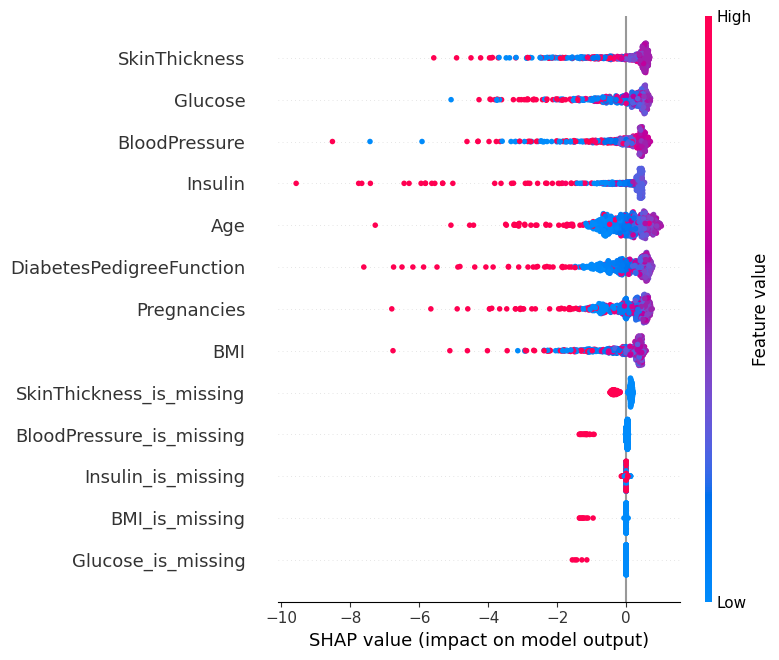

In [7]:
#  Baseline SHAP Analysis (New Block)

# Create a weighted summary of the baseline data for the KernelExplainer background
background_summary = shap.kmeans(X_base_scaled, 100)

# Initialize the Explainer using the OCSVM's scoring function
explainer = shap.KernelExplainer(oc_svm.decision_function, background_summary)
print("SHAP explainer created successfully (using oc_svm.decision_function).")

# Calculating the SHAP values for the baseline data
print("\nCalculating SHAP values for BASELINE data...")

# Suppress UserWarning about feature names being converted to positionals
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    shap_values_base = explainer.shap_values(X_base_scaled)

# Plot the SHAP summary for our baseline
print("Plotting SHAP summary for BASELINE data...")
print("--- SHAP OCSVM BASELINE PLOT ---")

# This plot shows what the model considers anomalous before any drift
shap.summary_plot(shap_values_base, X_base_scaled, plot_type="dot")

In [8]:
# Calculate Baseline Min/Max Stats for Correct Drift Simulation

print("Calculating baseline statistics for drift function.")

# Features that will be subject to drift (Glucose, BMI, Age)
features_to_drift = ['Glucose', 'BMI', 'Age']
X_base_stats = {}

for feature in features_to_drift:
    if feature in X_base_raw.columns:
        # Calculate stats only on non-NaN values in the BASELINE set
        f_min = np.nanmin(X_base_raw[feature])
        f_max = np.nanmax(X_base_raw[feature])
        f_range = f_max - f_min
        
        X_base_stats[feature] = {
            'f_min': f_min,
            'f_range': f_range
        }
        print(f" - {feature}: f_min={f_min:.3f}, f_max={f_max:.3f}")

print("Baseline statistics stored in X_base_stats.")

Calculating baseline statistics for drift function.
 - Glucose: f_min=44.000, f_max=197.000
 - BMI: f_min=18.200, f_max=67.100
 - Age: f_min=21.000, f_max=81.000
Baseline statistics stored in X_base_stats.


#### Experiment 1: Univariate Min/Max Drift (Glucose Only)

**Purpose:** Simulate the first drift scenario by applying the defined min/max affine transformation to only the **'Glucose'** feature in the raw test set. This tests the OCSVM model's sensitivity to a single-feature distribution shift.

**Workflow:**
1.  **Drift Application:** The `apply_minmax_drift` function is used on `X_test_raw` (unimputed data) for 'Glucose' only.
2.  **Preprocessing:** The baseline-fitted Imputer and Scaler are reapplied to the newly drifted test data. This is critical as it simulates a deployed pipeline where new, drifted data is processed by historical transformers.
3.  **Scoring:** The trained OCSVM model scores the scaled, drifted test data.
4.  **Metrics:** The resulting `Univariate Test Anomaly Rate` is calculated and compared to the `Baseline Anomaly Rate` to quantify the detection signal via the **Detection Ratio**.

In [9]:
# Experiment 1: Univariate Min/Max Drift (Glucose Only)
#Defining the feature for our univariate test
drift_features_uni = ['Glucose']
print (f"--- Running Univariate Experiment: Drifting {drift_features_uni} --")

# This prevents the FutureWarning by ensuring the columns can accept float values
X_test_raw_float_uni = X_test_raw.copy()
for col in continuous_cols:
    X_test_raw_float_uni[col] = X_test_raw_float_uni[col].astype(float) 

# Now we will apply min/max drift to the RAW (float-cast) test data
X_test_drifted_raw_uni = apply_minmax_drift(
    X_test_raw_float_uni, # Data to be drifted (test set)
    X_base_stats, # Baseline statistics
    features=drift_features_uni,
    shift_f=shift_factor,
    range_f=range_factor,
    verbose=True
)
# Apply the "Impute THEN Scale" pipeline to the newly drifted data
print("\nApplying baseline-fitted 'Impute -> Scale' pipeline...")
# First, impute the drifted raw data
X_test_drifted_imputed_cont_uni = imputer.transform(X_test_drifted_raw_uni[continuous_cols])
#Second, scale the imputed data using the baseline scaler
X_test_drifted_scaled_cont_uni = scaler.transform(X_test_drifted_imputed_cont_uni)
# Finally, recombine with the binary indicator columns
X_test_scaled_uni = pd.concat([
    X_test_drifted_scaled_cont_uni,
    X_test_drifted_raw_uni[indicator_cols]
], axis=1)
print("Univariate pipeline complete.")
# Scoring the new drifted data
print("\n--- Univariate Scoring Results (OCSVM) ---")
# Get the raw anomaly scores from the model (distance to hyperplane)
test_scores_uni = oc_svm.decision_function(X_test_scaled_uni)
#Get the binary predictions (-1 for anomaly, 1 for normal)
test_predictions_uni = oc_svm.predict(X_test_scaled_uni)
# Count how many samples are flagged as anomalous
test_anomaly_count_uni = (test_predictions_uni == -1).sum()
# Calculate the percentage of anomalies
test_anomaly_rate_uni = test_anomaly_count_uni / len(test_predictions_uni)
# Recalculate the baseline anomaly rate using the OCSVM
baseline_predictions = oc_svm.predict(X_base_scaled)
baseline_anomaly_rate = (baseline_predictions == -1).sum() / len(baseline_predictions)
print (f" Baseline Anomaly Rate: {baseline_anomaly_rate:.2%} ")
print (f" Univariate Test Anomaly Rate: {test_anomaly_rate_uni:.2%}")
# Computing the detection ratio
detection_ratio_uni = (
    test_anomaly_rate_uni / baseline_anomaly_rate if baseline_anomaly_rate > 0
    else 0
)
print("\nDETECTION METRICS (UNIVARIATE):")
print (f" Detection Ratio: {detection_ratio_uni:.3f}x")

--- Running Univariate Experiment: Drifting ['Glucose'] --
MIN/MAX AFFINE DRIFT TRANSFORMATION (NaN-Safe - BASELINE-FITTED)
Shift Factor: 0.4 | Range Factor: 1.5
Features: ['Glucose']

Glucose:
 Original (BASELINE): [44.000, 197.000]
 Drifted (TARGET): [17.600, 247.100]
 Test Set: mean=122.104, std=30.593
 Drifted Test: mean=134.756, std=45.889
 → Mean shift: +10.362% | Std change: +50.000%

Applying baseline-fitted 'Impute -> Scale' pipeline...
Univariate pipeline complete.

--- Univariate Scoring Results (OCSVM) ---
 Baseline Anomaly Rate: 21.23% 
 Univariate Test Anomaly Rate: 31.17%

DETECTION METRICS (UNIVARIATE):
 Detection Ratio: 1.468x


#### Validation and Interpretation (Univariate)

**Purpose:** Validate the detection signal from the OCSVM model and interpret the feature contribution using SHAP.

**K-S Test:** We apply the two-sample Kolmogorov-Smirnov test to the 'Glucose' feature (which was intentionally drifted) and two control features ('BMI' and 'Age'). The K-S test statistically confirms whether the distribution of the baseline data is significantly different from the post-drift test data (i.e., $p < 0.05$).

**SHAP Interpretation:** We generate a SHAP summary plot for the drifted test data ($\text{X}_{\text{test\_scaled\_uni}}$). This visualizes the OCSVM's reasoning, confirming that the new anomalies are primarily driven by the changes in the **'Glucose'** feature, validating the experimental design.

VALIDATING: Univariate Drift (on ['Glucose']) with OCSVM
--- Feature: Glucose ---
 Baseline Mean: 0.000
 Drifted Mean: 0.438
 P-value: 9.2328e-04
 Conclusion: Distributions are DIFFERENT (Drift Confirmed).

--- Feature: BMI ---
 Baseline Mean: -0.000
 Drifted Mean: 0.048
 P-value: 7.6733e-01
 Conclusion: Distributions are NOT different (No Drift).

--- Feature: Age ---
 Baseline Mean: 0.000
 Drifted Mean: 0.044
 P-value: 5.0650e-01
 Conclusion: Distributions are NOT different (No Drift).


Calculating SHAP values for OCSVM UNIVARIATE drift...


  0%|          | 0/231 [00:00<?, ?it/s]

Plotting SHAP summary for OCSVM UNIVARIATE drift...
--- SHAP OCSVM UNIVARIATE PLOT ---


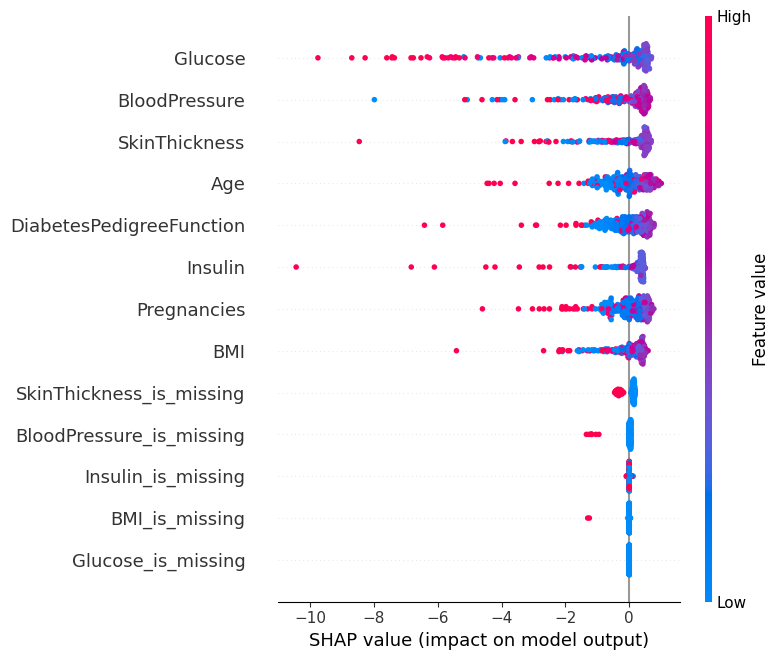

In [10]:
# Validation 1: K-S Test & SHAP (Univariate)

# Re-initialize the explainer using the OCSVM's decision_function
background_summary = shap.kmeans(X_base_scaled, 100)
explainer = shap.KernelExplainer(oc_svm.decision_function, background_summary) 

print("="*60)
print(f"VALIDATING: Univariate Drift (on {drift_features_uni}) with OCSVM")
print("="*60)

# Running the K-S Test validation
# We will loop through the drifted feature and two control features
for feature in ['Glucose', 'BMI', 'Age']: # Test drifted feature + 2 controls
    # Get the original baseline data (scaled)
    baseline_sample = X_base_scaled[feature]
    # Get the new drifted data (scaled)
    drifted_sample = X_test_scaled_uni[feature]
    
    # Compute the K-S test
    ks_stat, p_value = ks_2samp(baseline_sample, drifted_sample)
    
    print(f"--- Feature: {feature} ---")
    print(f" Baseline Mean: {baseline_sample.mean():.3f}")
    print(f" Drifted Mean: {drifted_sample.mean():.3f}")
    print(f" P-value: {p_value:.4e}")
    
    # Check if the p-value is significant (alpha = 0.05)
    if p_value < 0.05:
        print(" Conclusion: Distributions are DIFFERENT (Drift Confirmed).\n")
    else:
        print(" Conclusion: Distributions are NOT different (No Drift).\n")

# Performing the SHAP Analysis for the univariate drift
print("\nCalculating SHAP values for OCSVM UNIVARIATE drift...")
# Compute the SHAP values for the drifted test set
# Note: This calculation may take some time.
shap_values_uni = explainer.shap_values(X_test_scaled_uni)

print("Plotting SHAP summary for OCSVM UNIVARIATE drift...")
print("--- SHAP OCSVM UNIVARIATE PLOT ---")

# This plot shows us why the model flagged new anomalies
shap.summary_plot(shap_values_uni, X_test_scaled_uni, plot_type="dot")

#### Experiment 2: Multivariate Min/Max Drift (Glucose, BMI, Age)

**Purpose:** Simulate a more complex and robust population shift by applying the min/max affine transformation simultaneously to 'Glucose', 'BMI', and 'Age'. This tests the OCSVM model's ability to detect drift when the anomaly signature is distributed across multiple features.

**Workflow:**
1.  **Drift Application:** The `apply_minmax_drift` function is used on `X_test_raw` for all three features.
2.  **Preprocessing:** The baseline-fitted Imputer and Scaler are reapplied to the newly multivariate drifted test data.
3.  **Scoring:** The trained OCSVM model scores this new scaled dataset.
4.  **Metrics:** The resulting **Multivariate Test Anomaly Rate** and **Detection Ratio** are calculated. We expect a significantly stronger signal (higher detection ratio) compared to the univariate experiment.

In [11]:
# Experiment 2: Multivariate Min/Max Drift (Glucose, BMI, Age)
# Define the features for our multivariate test
drift_features_multi = ['Glucose', 'BMI', 'Age']
print(f"--- Running Multivariate Experiment: Drifting {drift_features_multi} ---")

# This prevents the FutureWarning by ensuring the columns can accept float values
X_test_raw_float_multi = X_test_raw.copy()
for col in continuous_cols:
    X_test_raw_float_multi[col] = X_test_raw_float_multi[col].astype(float) 

# Now we will apply min/max drift to the RAW (float-cast) test data
X_test_drifted_raw_multi = apply_minmax_drift(
    X_test_raw_float_multi, # Data to be drifted (test set)
    X_base_stats, # Baseline statistics
    features=drift_features_multi,
    shift_f=shift_factor,
    range_f=range_factor,
    verbose=True
)

# Apply the "Impute THEN Scale" pipeline to this multivariate drifted data
print("\nApplying baseline-fitted 'Impute -> Scale' pipeline...")
# Imputing the drifted raw data first
X_test_drifted_imputed_cont_multi = imputer.transform(X_test_drifted_raw_multi[continuous_cols])
#Scaling the imputed data with the baseline scaler
X_test_drifted_scaled_cont_multi = scaler.transform(X_test_drifted_imputed_cont_multi)
# Now we recombine with the binary indicator columns
X_test_scaled_multi = pd.concat([
    X_test_drifted_scaled_cont_multi,
    X_test_drifted_raw_multi[indicator_cols]
], axis=1)
print("Multivariate pipeline complete.")

#3. Score the new multivariate drifted data
print("\n--- Multivariate Scoring Results (OCSVM) ---")
# Get the raw anomaly scores
test_scores_multi = oc_svm.decision_function(X_test_scaled_multi)
# Get the binary predictions
test_predictions_multi = oc_svm.predict(X_test_scaled_multi)
# Count the new anomalies
test_anomaly_count_multi = (test_predictions_multi == -1).sum()
# Calculate the new anomaly rate
test_anomaly_rate_multi = test_anomaly_count_multi / len(test_predictions_multi)
#Print the comparison of anomaly rates (using baseline rate calculated in [8])
print (f" Baseline Anomaly Rate: {baseline_anomaly_rate:.2%}")
print(f" Multivariate Test Anomaly Rate: {test_anomaly_rate_multi:.2%}")
# Computing the final detection ratio
detection_ratio_multi = (
    test_anomaly_rate_multi / baseline_anomaly_rate if baseline_anomaly_rate > 0
    else 0
)
print("\nDETECTION METRICS (MULTIVARIATE):")
print (f" Detection Ratio: {detection_ratio_multi:.3f}x")

--- Running Multivariate Experiment: Drifting ['Glucose', 'BMI', 'Age'] ---
MIN/MAX AFFINE DRIFT TRANSFORMATION (NaN-Safe - BASELINE-FITTED)
Shift Factor: 0.4 | Range Factor: 1.5
Features: ['Glucose', 'BMI', 'Age']

Glucose:
 Original (BASELINE): [44.000, 197.000]
 Drifted (TARGET): [17.600, 247.100]
 Test Set: mean=122.104, std=30.593
 Drifted Test: mean=134.756, std=45.889
 → Mean shift: +10.362% | Std change: +50.000%

BMI:
 Original (BASELINE): [18.200, 67.100]
 Drifted (TARGET): [7.280, 80.630]
 Test Set: mean=32.692, std=6.456
 Drifted Test: mean=29.018, std=9.684
 → Mean shift: -11.239% | Std change: +50.000%

Age:
 Original (BASELINE): [21.000, 81.000]
 Drifted (TARGET): [8.400, 98.400]
 Test Set: mean=33.602, std=11.917
 Drifted Test: mean=27.303, std=17.875
 → Mean shift: -18.746% | Std change: +50.000%

Applying baseline-fitted 'Impute -> Scale' pipeline...
Multivariate pipeline complete.

--- Multivariate Scoring Results (OCSVM) ---
 Baseline Anomaly Rate: 21.23%
 Multivari

#### Validation and Interpretation (Multivariate)

**Purpose:** Validate the strong detection signal observed in the multivariate experiment and interpret the feature contributions using SHAP. This step statistically proves that the combined drift in 'Glucose', 'BMI', and 'Age' created a measurable shift, and confirms that the OCSVM model used these three features as the primary reason for flagging new anomalies.

**K-S Test:** We apply the two-sample Kolmogorov-Smirnov test to all three drifted features ('Glucose', 'BMI', and 'Age'). We expect the $p$-value for all three features to be highly significant ($p \ll 0.05$), confirming that the min/max affine transformation created a statistically measurable distribution shift.

**SHAP Interpretation:** We generate the final SHAP summary plot for the multivariate drifted test data ($\text{X}_{\text{test\_scaled\_multi}}$). We anticipate seeing all three drifted features—**'Glucose', 'BMI', and 'Age'**—dominate the plot, providing the definitive explainability layer to validate our drift detection.

VALIDATING: Multivariate Drift (on ['Glucose', 'BMI', 'Age']) with OCSVM
--- Feature: Glucose ---
 Baseline Mean: 0.000
 Drifted Mean: 0.438
 P-value: 9.2328e-04
 Conclusion: Distributions are DIFFERENT (Drift Confirmed).

--- Feature: BMI ---
 Baseline Mean: -0.000
 Drifted Mean: -0.469
 P-value: 1.1062e-08
 Conclusion: Distributions are DIFFERENT (Drift Confirmed).

--- Feature: Age ---
 Baseline Mean: 0.000
 Drifted Mean: -0.495
 P-value: 4.7631e-39
 Conclusion: Distributions are DIFFERENT (Drift Confirmed).


Calculating SHAP values for OCSVM MULTIVARIATE drift...


  0%|          | 0/231 [00:00<?, ?it/s]

Plotting SHAP summary for OCSVM MULTIVARIATE drift...
--- SHAP OCSVM MULTIVARIATE PLOT ---


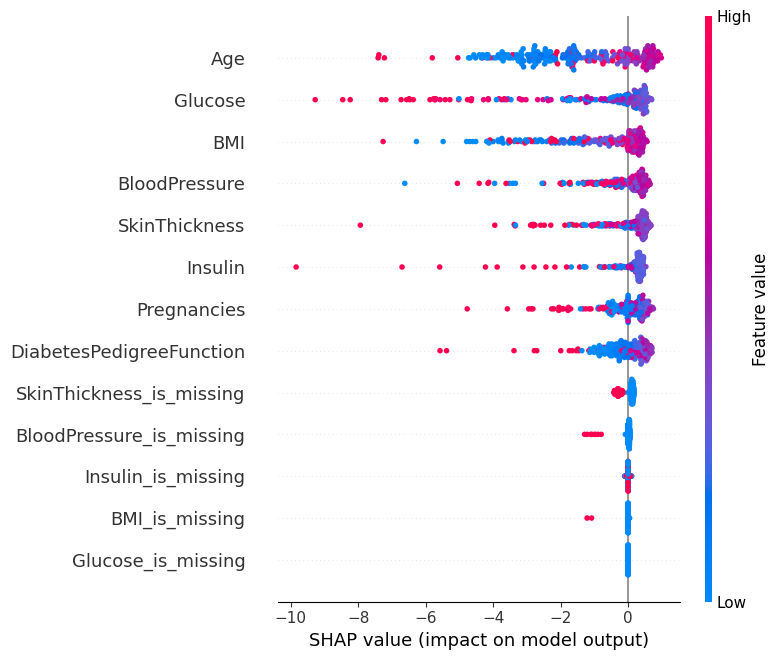

In [12]:
# Validation 2: K-S Test & SHAP (Multivariate)
# Re-initialize the explainer using the OCSVM's decision_function
background_summary = shap.kmeans(X_base_scaled, 100)
explainer = shap.KernelExplainer(oc_svm.decision_function, background_summary) 

drift_features_multi = ['Glucose', 'BMI', 'Age']

print("="*60)
print(f"VALIDATING: Multivariate Drift (on {drift_features_multi}) with OCSVM")
print("="*60)

# Now we will validate the multivariate drift using the K-S test
# Loop through each feature that we drifted
for feature in drift_features_multi:
    # Get the original baseline data (scaled)
    baseline_sample = X_base_scaled[feature]
    # Get the new multivariate drifted data (scaled)
    drifted_sample = X_test_scaled_multi[feature]
    
    # Compute the K-S test
    ks_stat, p_value = ks_2samp(baseline_sample, drifted_sample)
    
    print(f"--- Feature: {feature} ---")
    print(f" Baseline Mean: {baseline_sample.mean():.3f}")
    print(f" Drifted Mean: {drifted_sample.mean():.3f}")
    print(f" P-value: {p_value:.4e}")
    
    # Checking if the distributions are statistically different (alpha = 0.05)
    if p_value < 0.05:
        print(" Conclusion: Distributions are DIFFERENT (Drift Confirmed).\n")
    else:
        print(" Conclusion: Distributions are NOT different (No Drift).\n")

# Performing the SHAP Analysis for multivariate drift
print("\nCalculating SHAP values for OCSVM MULTIVARIATE drift...")

# Compute the SHAP values for the drifted test set
# Suppress UserWarning about feature names being converted to positionals
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    shap_values_multi = explainer.shap_values(X_test_scaled_multi)

print("Plotting SHAP summary for OCSVM MULTIVARIATE drift...")
print("--- SHAP OCSVM MULTIVARIATE PLOT ---")

# This plot will show all three features contributing to the anomaly scores
shap.summary_plot(shap_values_multi, X_test_scaled_multi, plot_type="dot")

##### ================================================================================================================
### 6. Conclusion: OCSVM Sensitivity to Abrupt Drift

This experiment successfully evaluated the **One-Class Support Vector Machine (OCSVM)** against a simulated Abrupt Min/Max Drift. By fixing the model's baseline sensitivity ($\nu=0.2$) to match the parallel Isolation Forest experiment (`contamination=0.2`), we established a controlled environment to compare the mechanistic responses of both algorithms.

#### 6.1 Quantitative Results & Benchmarking

The table below summarizes the OCSVM performance and benchmarks it directly against the Isolation Forest results obtained under identical drift conditions.

| Drift Scenario | New Anomaly Rate (OCSVM) | **OCSVM Detection Ratio** | Isolation Forest Ratio | Relative Performance |
| :--- | :--- | :--- | :--- | :--- |
| **Baseline** | 21.23% | $1.00\text{x}$ | $1.00\text{x}$ | *Control* |
| **Univariate** (Glucose) | 31.17% | **$1.47\text{x}$** | $1.14\text{x}$ | **OCSVM (+29%)** |
| **Multivariate** (3 Feat.) | 61.90% | **$2.92\text{x}$** | $1.42\text{x}$ | **OCSVM (+105%)** |

*Note: Relative Performance indicates the percentage improvement of OCSVM over IF.*

#### 6.2 Critical Analysis

**1. Mechanism of Superiority (Kernel vs. Partitioning)**
The OCSVM demonstrated superior sensitivity to this specific Abrupt Drift type, achieving a **$2.92\text{x}$ detection ratio** in the multivariate scenario compared to the Isolation Forest's $1.42\text{x}$.
* **Interpretation:** The Min/Max Affine transformation creates a systemic shift that pushes data points away from the dense "core." The OCSVM's RBF kernel, which defines a smooth, distance-based boundary around this core, was more effective at recognizing these shifted points as outliers than the axis-parallel partitioning of the Isolation Forest. 

**2. Multivariate Amplification**
The OCSVM's response was non-linear with respect to feature involvement. While univariate drift yielded a moderate increase ($1.47\text{x}$), adding correlated drift (BMI + Age) nearly doubled the sensitivity ($2.92\text{x}$). This confirms the model successfully exploits feature correlations to identify systemic population shocks.

**3. Attribution & Validity**
The validity of these findings is supported by two distinct validation layers:
* **Statistical:** K-S tests confirmed that the underlying distributions for *Glucose*, *BMI*, and *Age* deviated significantly ($p < 0.05$) from the training baseline.
* **Explainability:** SHAP analysis correctly attributed the anomaly score spikes to the drifted features, validating that the model was reacting to the simulated signal rather than noise.

### 6.3 Final Verdict

While previous experiments indicated that **Isolation Forest** excels at detecting *Gradual Multiplicative Drift*, this result proves that **OCSVM** is significantly more robust against *Abrupt Affine Shifts*. This dichotomy highlights a critical operational insight: **Algorithm selection must be tailored to the specific morphology of the anticipated failure mode.**